收斂於第 34 次迭代


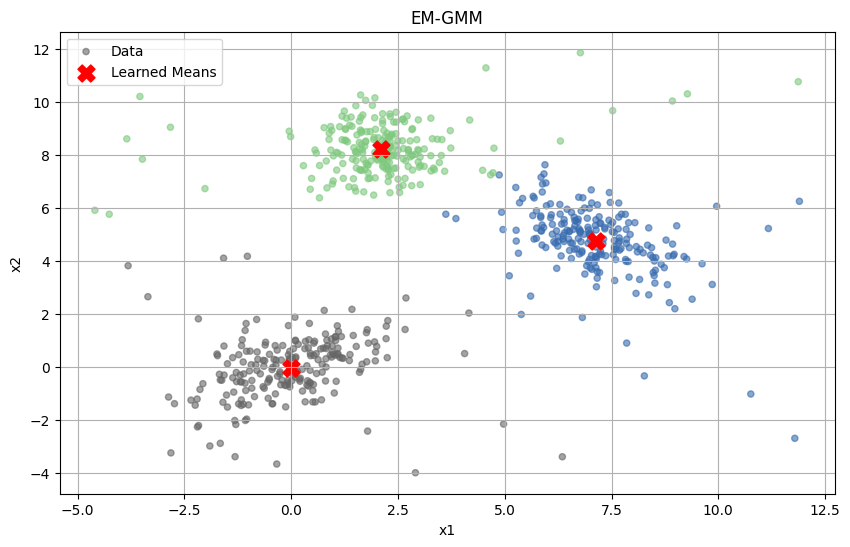

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# === 1. 產生模擬資料（3群 + 雜訊）===
np.random.seed(42)

mean1 = [0, 0]
cov1 = [[1.5, 0.7], [0.7, 1.0]]
data1 = np.random.multivariate_normal(mean1, cov1, 200)

mean2 = [7, 5]
cov2 = [[1.0, -0.6], [-0.6, 1.0]]
data2 = np.random.multivariate_normal(mean2, cov2, 200)

mean3 = [2, 8]
cov3 = [[0.5, 0], [0, 0.8]]
data3 = np.random.multivariate_normal(mean3, cov3, 200)

# 加入雜訊（uniform noise）
noise = np.random.uniform(low=-5, high=12, size=(50, 2))

X = np.vstack((data1, data2, data3, noise))
n_samples, n_features = X.shape
K = 3  # 預設學 3 群

# === 2. 參數初始化 ===
np.random.seed(0)
pi = np.ones(K) / K
mu = X[np.random.choice(n_samples, K, replace=False)]
sigma = [np.eye(n_features) for _ in range(K)]

# === 3. EM 演算法 ===
def gmm_em(X, mu, sigma, pi, max_iter=100, tol=1e-5):
    n, d = X.shape
    K = len(pi)
    log_likelihoods = []

    for iteration in range(max_iter):
        # --- E-step ---
        gamma = np.zeros((n, K))
        for k in range(K):
            gamma[:, k] = pi[k] * multivariate_normal.pdf(X, mean=mu[k], cov=sigma[k])
        gamma /= np.sum(gamma, axis=1, keepdims=True)

        # --- M-step ---
        Nk = np.sum(gamma, axis=0)
        pi = Nk / n
        mu = (gamma.T @ X) / Nk[:, np.newaxis]
        sigma = []
        for k in range(K):
            X_centered = X - mu[k]
            cov_k = (gamma[:, k][:, np.newaxis] * X_centered).T @ X_centered / Nk[k]
            sigma.append(cov_k)

        # --- Log-likelihood ---
        log_likelihood = np.sum(np.log(np.sum([
            pi[k] * multivariate_normal.pdf(X, mean=mu[k], cov=sigma[k])
            for k in range(K)
        ], axis=0)))
        log_likelihoods.append(log_likelihood)

        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            print(f"收斂於第 {iteration} 次迭代")
            break

    return mu, sigma, pi, gamma, log_likelihoods

# 執行 EM
mu_final, sigma_final, pi_final, gamma_final, logL = gmm_em(X, mu, sigma, pi)

# === 4. 視覺化 ===
labels = np.argmax(gamma_final, axis=1)

plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='Accent', s=20, alpha=0.6, label='Data')
plt.scatter(mu_final[:, 0], mu_final[:, 1], c='red', marker='X', s=150, label='Learned Means')
plt.title("EM-GMM")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True)
plt.legend()
plt.show()